In [2]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot

Welcome to JupyROOT 6.24/00


In [3]:
templatefile = ROOT.TFile.Open('templates/AD_Templates.root',"READ")
muonfile = ROOT.TFile.Open('AD1_Wet_MuonTracking.root', "READ")

Warning in <TClass::Init>: no dictionary for class TCumulativeMap<string,double> is available
Warning in <TClass::Init>: no dictionary for class TCumulative is available
Warning in <TClass::Init>: no dictionary for class CumulativeData is available


In [4]:
graph_early = templatefile.Get("gPSD_Template_0_0")
graph_late = templatefile.Get("gPSD_Template_0_1")
PSDvE = muonfile.Get("MuonTracking/hPSDvE")

In [5]:
def get_xy_from_TGraph(graph): 
    
    n = graph.GetN()
    
    x = np.asarray([])
    y = np.asarray([])

    for i in range(n): 
        x = np.append(x, graph.GetPointX(i))
        y = np.append(y, graph.GetPointY(i))
        
    return x, y


In [6]:
x,y = get_xy_from_TGraph(graph_early)
x1, y1 = get_xy_from_TGraph(graph_late)
half_max = np.amax(y)/2

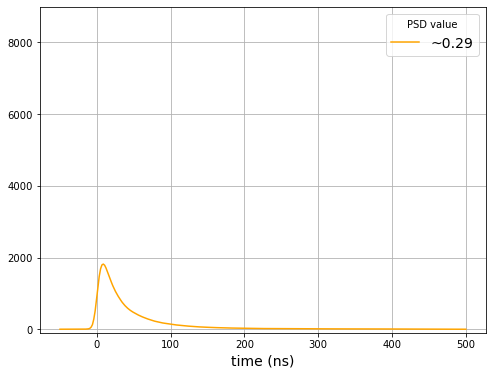

In [24]:
#plt.plot(x,y, linestyle='-', marker='', label='~0.13')
plt.plot(x1,y1, linestyle='-', marker='', label='~0.29', color='orange')
#plt.plot([x[0],x[-1]], [half_max,half_max], linestyle='-', marker='', color='r')
plt.grid()
plt.xlabel('time (ns)', fontsize=14)
plt.legend(title='PSD value', fontsize=14)
plt.ylim(-100,9000)
plt.rcParams["figure.figsize"] = (8,6)

In [28]:
def waveform_integral(xarray,yarray, intmin, intmax): 
    
    xarraycut = np.asarray([xarray[i] for i in range(len(xarray)) if intmin<xarray[i]<intmax])
    yarraycut = np.asarray([yarray[i] for i in range(len(xarray)) if intmin<xarray[i]<intmax])
    
    ymin_extra = np.interp(intmin, xarray, yarray)
    ymax_extra = np.interp(intmax, xarray, yarray)
    
    xarraycut = np.concatenate([[intmin],xarraycut,[intmax]])
    yarraycut = np.concatenate([[ymin_extra],yarraycut,[ymax_extra]])
    
    return np.trapz(yarraycut, x=xarraycut)

def get_time(xarray, yarray):
    
    half_max = np.amax(yarray)/2
    
    xarraycut = np.asarray([xarray[i] for i in range(len(xarray)) if -20<xarray[i]<20])
    yarraycut = np.asarray([yarray[i] for i in range(len(xarray)) if -20<xarray[i]<20])
    
    return np.interp(half_max, yarraycut, xarraycut, left=float('NaN'), right=float('NaN')) 

def get_total_area(xarray,yarray): 
    
    minx = np.amin(xarray)
    maxx = np.amax(xarray)
    
    return waveform_integral(xarray,yarray, intmin=minx, intmax=maxx) 

def get_PSD(xarray, yarray): 
    
    time = get_time(xarray, yarray)
    
    total = waveform_integral(xarray,yarray, intmin=-12+time, intmax=200+time)
    tail  =  waveform_integral(xarray,yarray, intmin=44+time, intmax=200+time)
    
    return tail/total
    
    

In [27]:
def scaling_scan(hmin, hmax, xarray, yarray, clipping_height):
    
    df = pd.DataFrame(columns=['dh', \
                               'scalefactor', \
                               'clipping_height', \
                               'ymax_unclipped', \
                               'ymax_clipped', \
                               'PSD_unclipped', \
                               'PSD_clipped', \
                               'totalarea_unclipped', \
                               'totalarea_clipped', \
                               'time_offset'])
    
    ymax = np.amax(yarray)
    #dh_array = np.arange(hmin, hmax, 300) - ymax
    dh_array = np.linspace(hmin, hmax, 500) - ymax
    
    for dh in dh_array: 
        
        scalefactor = (ymax + dh)/ymax
        
        yscaled = yarray*scalefactor
        yscaled_clipped = np.copy(yscaled)
        
        yscaled_clipped[yscaled_clipped > clipping_height] = clipping_height
        
        dh = dh
        scalefactor = scalefactor
        clipping_height = clipping_height
        ymax_unclipped = np.amax(yscaled)
        ymax_clipped = np.amax(yscaled_clipped)
        PSD_unclipped = get_PSD(xarray, yscaled)
        PSD_clipped = get_PSD(xarray, yscaled_clipped)
        totalarea_unclipped = get_total_area(xarray, yscaled)
        totalarea_clipped = get_total_area(xarray, yscaled_clipped) 
        time_offset = get_time(xarray, yscaled_clipped) - get_time(xarray, yscaled)
        
        df.loc[len(df)] = [dh, \
                           scalefactor, \
                           clipping_height, \
                           ymax_unclipped, \
                           ymax_clipped, \
                           PSD_unclipped, \
                           PSD_clipped, \
                           totalarea_unclipped, \
                           totalarea_clipped, \
                           time_offset]
        
    return df
    

### Using Combined 2 Waveforms

In [29]:
x,y = get_xy_from_TGraph(graph_early)
df_early = scaling_scan(hmin=0.01, hmax=np.amax(y)*200, xarray=x, yarray=y, clipping_height=80000)
x,y = get_xy_from_TGraph(graph_late)
df_late = scaling_scan(hmin=0.01, hmax=np.amax(y)*200, xarray=x, yarray=y, clipping_height=80000)

df_late = df_late.iloc[1:]
df_early = df_early.iloc[1:]

In [39]:
df_early

,dh,scalefactor,clipping_height,ymax_unclipped,ymax_clipped,PSD_unclipped,PSD_clipped,totalarea_unclipped,totalarea_clipped,time_offset
1,-5.295217e+03,0.400803,80000.0,3.541968e+03,3541.967697,0.129536,0.129536,1.082977e+05,1.082977e+05,0.000000
2,-1.753259e+03,0.801604,80000.0,7.083925e+03,7083.925393,0.129536,0.129536,2.165951e+05,2.165951e+05,0.000000
3,1.788699e+03,1.202406,80000.0,1.062588e+04,10625.883090,0.129536,0.129536,3.248925e+05,3.248925e+05,0.000000
4,5.330656e+03,1.603208,80000.0,1.416784e+04,14167.840787,0.129536,0.129536,4.331899e+05,4.331899e+05,0.000000
5,8.872614e+03,2.004009,80000.0,1.770980e+04,17709.798484,0.129536,0.129536,5.414873e+05,5.414873e+05,0.000000
...,...,...,...,...,...,...,...,...,...,...
495,1.744432e+06,198.396794,80000.0,1.753269e+06,80000.000000,0.129536,0.626007,5.360721e+07,1.109200e+07,-8.501859
496,1.747974e+06,198.797595,80000.0,1.756811e+06,80000.000000,0.129536,0.626285,5.371551e+07,1.110226e+07,-8.506512
497,1.751516e+06,199.198397,80000.0,1.760353e+06,80000.000000,0.129536,0.626563,5.382381e+07,1.111252e+07,-8.511146
498,1.755058e+06,199.599198,80000.0,1.763895e+06,80000.000000,0.129536,0.626840,5.393210e+07,1.112278e+07,-8.515762


In [40]:
df_late

,dh,scalefactor,clipping_height,ymax_unclipped,ymax_clipped,PSD_unclipped,PSD_clipped,totalarea_unclipped,totalarea_clipped,time_offset
1,-1088.895918,0.400807,80000.0,728.375129,728.375129,0.29219,0.292190,3.207680e+04,3.207680e+04,0.000000
2,-360.530789,0.801609,80000.0,1456.740258,1456.740258,0.29219,0.292190,6.415317e+04,6.415317e+04,0.000000
3,367.834340,1.202410,80000.0,2185.105387,2185.105387,0.29219,0.292190,9.622953e+04,9.622953e+04,0.000000
4,1096.199469,1.603212,80000.0,2913.470516,2913.470516,0.29219,0.292190,1.283059e+05,1.283059e+05,0.000000
5,1824.564598,2.004013,80000.0,3641.835645,3641.835645,0.29219,0.292190,1.603823e+05,1.603823e+05,0.000000
...,...,...,...,...,...,...,...,...,...,...
495,358723.477856,198.396794,80000.0,360540.748903,80000.000000,0.29219,0.569250,1.587780e+07,8.827480e+06,-5.030802
496,359451.842985,198.797595,80000.0,361269.114032,80000.000000,0.29219,0.569625,1.590988e+07,8.835832e+06,-5.035587
497,360180.208114,199.198397,80000.0,361997.479161,80000.000000,0.29219,0.569999,1.594195e+07,8.844183e+06,-5.040354
498,360908.573243,199.599198,80000.0,362725.844290,80000.000000,0.29219,0.570371,1.597403e+07,8.852535e+06,-5.045101


In [30]:


combinedarea = np.asarray(df_early['totalarea_clipped']) + np.asarray(df_late['totalarea_clipped'])

scaledPSD_early = np.asarray(df_early['PSD_clipped'])*np.asarray(df_early['totalarea_clipped'])/combinedarea
scaledPSD_late = np.asarray(df_late['PSD_clipped'])*np.asarray(df_late['totalarea_clipped'])/combinedarea

combinedPSD = scaledPSD_early + scaledPSD_late




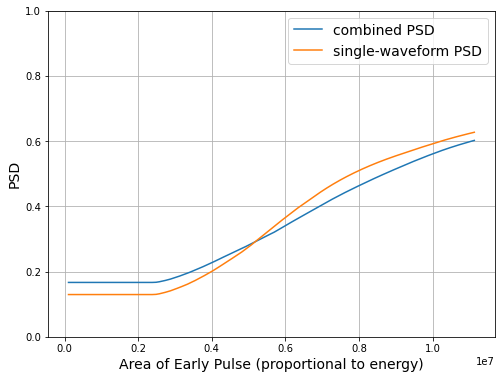

In [41]:
plt.plot(np.asarray(df_early['totalarea_clipped']), combinedPSD, marker='', linestyle='-', label='combined PSD')
plt.plot(np.asarray(df_early['totalarea_clipped']), np.asarray(df_early['PSD_clipped']), marker='', linestyle='-', label='single-waveform PSD')
plt.grid()
plt.ylim(0,1)
plt.xlabel('Area of Early Pulse (proportional to energy)', fontsize=14)
plt.ylabel('PSD', fontsize=14)
plt.title('')
plt.legend(fontsize=14)
plt.rcParams["figure.figsize"] = (8,6)

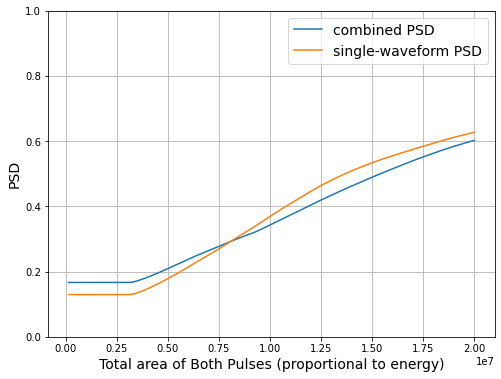

In [43]:
plt.plot(combinedarea, combinedPSD, marker='', linestyle='-', label='combined PSD')
plt.plot(combinedarea, np.asarray(df_early['PSD_clipped']), marker='', linestyle='-', label='single-waveform PSD')
plt.grid()
plt.ylim(0,1)
plt.xlabel('Total area of Both Pulses (proportional to energy)', fontsize=14)
plt.ylabel('PSD', fontsize=14)
plt.title('')
plt.legend(fontsize=14)
plt.rcParams["figure.figsize"] = (8,6)

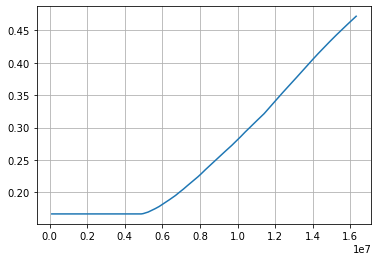

In [106]:
plt.plot(np.asarray(df_early['totalarea_clipped']), combinedPSD, marker='', linestyle='-')
plt.grid()

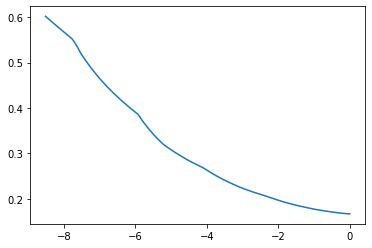

In [101]:
plt.plot(np.asarray(df_early['time_offset']), combinedPSD, marker='', linestyle='-')

In [36]:
PSDvE_graph_combined = ROOT.TGraph( len(combinedPSD), 0.000012*np.asarray(df_early['totalarea_clipped']), combinedPSD)
PSDvE_graph = ROOT.TGraph( len(combinedPSD), 0.000012*np.asarray(df_early['totalarea_clipped']), np.asarray(df_early['PSD_clipped']))

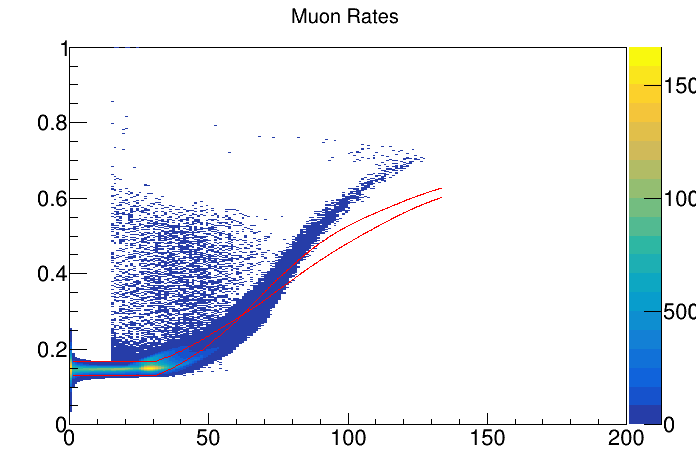

In [38]:
c1 = ROOT.TCanvas()
PSDvE.Draw('colz')
PSDvE_graph_combined.SetLineColor(2);
PSDvE_graph_combined.Draw('L')
PSDvE_graph.SetLineColor(2);
PSDvE_graph.Draw('L')

c1.Draw()

In [ ]:
file = uproot.open('AD1_Wet_MuonTracking.root')
PSDvE_np = file["MuonTracking/hPSDvE"].to_hist()

AttributeError: module 'matplotlib.pyplot' has no attribute 'zscale'

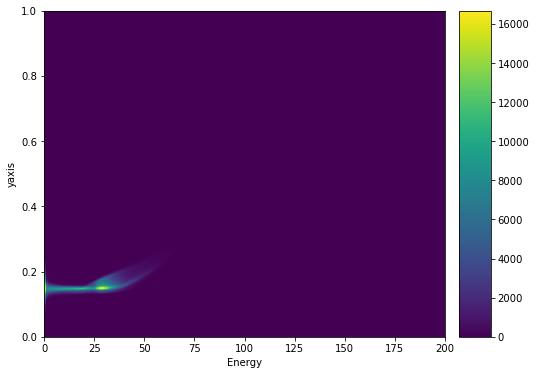

In [144]:
PSDvE_np.plot()
plt.xlabel('Energy')
plt.zscale('log')